# Running a full NEB workflow for migration energy barrier calculations with NEB and MACE

This tutorial shows how to run a vacancy diffusion workflow using the Forge Package. 

The workflow is as follows:
1. Create a random alloy composition
2. Run Monte Carlo to get an energetically favorable order for the structure
3. Relax the alloy structure and it's cell
4. Pick a vacancy index randomly from the structure
5. Sample the nearest and next nearest neighbors of the vacancy
6. Run the vacancy diffusion using the DyNEB method on the vacancy and the target index (picked at random from the nearest neighbors)
7. Relax the vacancy start and end points (handled in the VacancyDiffusion object)
8. Run the NEB simulation 
9. Plot the migration energy barrier


## Loading the necessary packages and modules for FORGE

In [2]:
import numpy as np 

from ase.build import bulk 
from forge.workflows.mcmc import MonteCarloAlloySampler
from mace.calculators.mace import MACECalculator 

# For Step 1, getting the composition we want. 
from forge.analysis.composition import CompositionAnalyzer
from math import ceil, floor

# For checking the device and getting absolute paths
import forge 
import torch
from pathlib import Path


# For creating the vacancy diffusion object in step 4-9
from forge.workflows.neb import VacancyDiffusion

# For plotting the scaled energies
import matplotlib.pyplot as plt

/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializat

## Creating the composition and initializing the random alloy structure

In [3]:
# set all the seeds
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [5]:
cubic = False
N = 16 # sets the size of the supercell
if cubic:
    num_atoms = 2*N**3 # if cubic = True
else:
    num_atoms = N**2 # if cubic = False

# Get the atomic fractions for the alloy correctly rounded to 4 decimal places for the given super cell size
x_zr = round(ceil(0.0025 * num_atoms)/num_atoms, 4)
x_cr = round(ceil(0.04 * num_atoms)/num_atoms, 4)
x_ti = round(ceil(0.05 * num_atoms)/num_atoms, 4)
x_w = round(ceil(0.05 * num_atoms)/num_atoms, 4)
x_v = round(1 - x_zr - x_cr - x_ti - x_w, 4)

# Adjust x_v if the sum of the composition is not 1
if x_zr + x_cr + x_ti + x_w + x_v != 1:
    x_v = 1 - x_zr - x_cr - x_ti - x_w
    
composition = {
    'V' : x_v,
    'Cr' : x_cr,
    'Ti' : x_ti,
    'W' : x_w,
    'Zr' : x_zr
}

print(f"The Composition of our alloy is {composition}")

The Composition of our alloy is {'V': 0.8515, 'Cr': 0.043, 'Ti': 0.0508, 'W': 0.0508, 'Zr': 0.0039}


Now we will create the randomly ordered alloy structure using the CompositionAnalyzer class. This creates an ASE atoms object. 

In [6]:
analyzer = CompositionAnalyzer()
atoms = analyzer.create_random_alloy(composition = composition, 
                                         crystal_type = 'bcc', 
                                         dimensions=[N,N,N], 
                                         lattice_constant = 3.01,
                                         balance_element = 'V', 
                                         cubic=cubic)

print(atoms)

Atoms(symbols='Cr177Ti209V3485W209Zr16', pbc=True, cell=[[-24.08, 24.08, 24.08], [24.08, -24.08, 24.08], [24.08, 24.08, -24.08]])


## Ordering and then Relaxing the alloy structure and it's cell

For this step, we will load the MACE model we want to use, run the Monte Carlo to get an energetically favorable order for the structure, and then relax the alloy structure and it's cell. 

In [7]:
# The model path should point to your MACE model that you want to use.
model_path = '../potentials/gen_6_model_0_L0_isolated-2026-01-16_stagetwo.model'

# This is some boiler plate code to check the device and enable CUEQ if we are using a GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    enable_cueq = True
else:
    enable_cueq = False

# Define the mace calculator
calc = MACECalculator(model_paths=[model_path],
                      device=device,
                      default_dtype="float32",
                      enable_cueq=enable_cueq)

# Attach the calculator to the atoms object
atoms.calc = calc

# Define the temperature and the number of steps per atom
temperature = 600+273.15
steps_per_atom = 30 # in this test we do only 1, in real life you want to do 50-100 steps per atom
total_swaps = steps_per_atom * len(atoms)

# Define the Monte Carlo sampler object
mc_sampler = MonteCarloAlloySampler(
    atoms=atoms,
    calculator=calc,
    temperature=temperature,
    steps=total_swaps,
)

# Run the Monte Carlo sampler
final_atoms = mc_sampler.run_mcmc()


/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc

Converting models to CuEq for acceleration


/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/mace/modules/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "atomic_numbers", torch.tensor(atomic_numbers, dtype=torch.int64)
Running MC: 100%|██████████| 122880/122880 [1:43:47<00:00, 19.73steps/s, energy=-37427.281 eV, Δe/atom=0.000408 eV] 


In [8]:
import os
from pathlib import Path

save_path = Path("../data/neb_workflow_data/")
save_path.mkdir(exist_ok=True)
# you can save the final atoms to a file if you want
final_atoms.write(os.path.join(save_path,f'{final_atoms.get_chemical_formula()}_relaxed.xyz'))


In [4]:
from ase.io import read
import os
save_path = Path("../data/neb_workflow_data/")
final_atoms = read('/home/myless/Packages/forge/scratch/data/neb_workflow_data/Cr177Ti209V3485W209Zr16_relaxed.xyz')

Here we use a wrapper for the ASE relaxation function to relax the structure and it's cell. 

In [5]:
# take in the final atoms and relax the structure 
from forge.workflows.relax import relax 

# This is some boiler plate code to check the device and enable CUEQ if we are using a GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    enable_cueq = True
else:
    enable_cueq = False

model_path = '../potentials/gen_6_model_0_L0_isolated-2026-01-16_stagetwo.model'

# Define the mace calculator
calc = MACECalculator(model_paths=[model_path],
                      device=device,
                      default_dtype="float32",
                      enable_cueq=enable_cueq)


relaxed_atoms = relax(atoms = final_atoms, 
                     calculator = calc, 
                     relax_cell = True, 
                     fmax = 0.05, 
                     steps = 200, 
                     optimizer = "FIRE",
                     verbose = 0,
                     interval = 0)



/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/mace/calculators/mace.py:135: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(f=model_path, map_loc

Converting models to CuEq for acceleration


/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/mace/modules/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "atomic_numbers", torch.tensor(atomic_numbers, dtype=torch.int64)
/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/ase/filters.py:600: RuntimeWarning: logm result may be inaccurate, approximate err = 1.4299129843471581e-12
  pos[natoms:] = self.logm(pos[natoms:]) * self.exp_cell_factor
/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/ase/filters.py:600: RuntimeWarning: logm result may be inaccurate, approximate err = 1.4283711427010772e-12
  pos[natoms:] = self.logm(pos[natoms:]) * self.exp_cell_factor
/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/ase/filters.py:600: RuntimeWarning: logm result may be inaccurate, approximate err = 1.4256254155868355e-

## Creating the vacancy diffusion object and running the vacancy diffusion NEB calculation

This step creates the VacancyDiffusion object and runs the vacancy diffusion NEB calculation on a single vacancy and target index. 

In [6]:
# create the VacancyDiffusion object

neb = VacancyDiffusion(atoms = relaxed_atoms,
                       model_path = model_path,
                       seed = seed
                       )

In this block we show how to extract the nearest and next nearest neighbors of the vacancy index. You can use the .sample_neighbors method from the VacancyDiffusion object to get the neighbors. It returns a dictionary with the vacancy index, the nearest neighbors, and the next nearest neighbors. 

In [7]:
from pathlib import Path

# get the vacancy index randomly from the len of atoms
vac_idx = np.random.randint(0, len(relaxed_atoms))

print(f"Vacancy index: {vac_idx}")

# get the neighbors of the vacancy index, #TODO separate the nearest and next nearest neighbors results, maybe using a dictionary 
neighbors = neb.sample_neighbors(vacancy_indices=[vac_idx], n_nearest=8, n_next_nearest=6)

# print the neighbors
print(f"Neighbors: {neighbors}")

# get the target index from the neighbors
tar_idx = neighbors[0]

print(f"Target index: {tar_idx}")


Vacancy index: 3174
Neighbors: [{'vacancy_index': 3174, 'nn': [3430, 3158, 3173, 2901, 3190, 2918, 3175, 3447], 'nnn': [3157, 3446, 2917, 3191, 3431, 2902]}]
Target index: {'vacancy_index': 3174, 'nn': [3430, 3158, 3173, 2901, 3190, 2918, 3175, 3447], 'nnn': [3157, 3446, 2917, 3191, 3431, 2902]}


To test how a single vacancy diffusion calculation works, we will run the vacancy diffusion calculation on the vacancy index and the target index (we just pick the first nearest neighbor). You can change the number of images, the neb method (although DyNEB is the fastest with no change in the barrier compared to VASP), whether or not we use climbing image (which is the default), and the relaxation parameters. Additionally you can change the seed for the random number generator, save the initial trajectory for debugging, and set the output directory to save the results. 

In [8]:
# run the vacancy diffusion
results = neb.run_single(vacancy_index=vac_idx,
               target_index=tar_idx['nn'][1],
               num_images=5,
               neb_method="dyneb",
               climb=True,
               save_xyz=True,
               relax_fmax=0.05,
               relax_steps=200,
               neb_fmax=0.05,
               neb_steps=200,
               verbose=2,
               output_dir=Path(".")
               )

INFO:forge.workflows.relax:Relaxing atomic positions with fixed unit cell
INFO:forge.workflows.relax:Starting optimization with FIRE, fmax=0.05, max steps=200


      Step     Time          Energy          fmax
FIRE:    0 18:01:09   -37462.484375        0.709481


INFO:forge.workflows.relax:Energy: -37462.484375 eV, Max force: 0.430573 eV/Å


FIRE:    1 18:01:09   -37462.527344        0.692572
FIRE:    2 18:01:09   -37462.550781        0.659493
FIRE:    3 18:01:10   -37462.632812        0.611129
FIRE:    4 18:01:10   -37462.679688        0.547594
FIRE:    5 18:01:10   -37462.773438        0.467498
FIRE:    6 18:01:10   -37462.820312        0.368342
FIRE:    7 18:01:11   -37462.847656        0.249263
FIRE:    8 18:01:11   -37462.867188        0.149240
FIRE:    9 18:01:11   -37462.828125        0.254625
FIRE:   10 18:01:11   -37462.847656        0.249296


INFO:forge.workflows.relax:Energy: -37462.847656 eV, Max force: 0.206735 eV/Å


FIRE:   11 18:01:11   -37462.820312        0.238810
FIRE:   12 18:01:12   -37462.847656        0.223544
FIRE:   13 18:01:12   -37462.867188        0.204020
FIRE:   14 18:01:12   -37462.851562        0.180940
FIRE:   15 18:01:12   -37462.859375        0.155151
FIRE:   16 18:01:13   -37462.867188        0.127671
FIRE:   17 18:01:13   -37462.859375        0.096838
FIRE:   18 18:01:13   -37462.878906        0.077446
FIRE:   19 18:01:13   -37462.855469        0.098529
FIRE:   20 18:01:14   -37462.906250        0.114987


INFO:forge.workflows.relax:Energy: -37462.906250 eV, Max force: 0.076107 eV/Å


FIRE:   21 18:01:14   -37462.882812        0.124242
FIRE:   22 18:01:14   -37462.867188        0.124329
FIRE:   23 18:01:14   -37462.898438        0.113644
FIRE:   24 18:01:14   -37462.882812        0.091033
FIRE:   25 18:01:15   -37462.863281        0.059387
FIRE:   26 18:01:15   -37462.871094        0.047541


INFO:forge.workflows.relax:Optimization completed after 26 steps
INFO:forge.workflows.relax:Final energy: -37462.871094 eV
INFO:forge.workflows.relax:Maximum force: 0.035232 eV/Å
INFO:forge.workflows.relax:Relaxing atomic positions with fixed unit cell
INFO:forge.workflows.relax:Starting optimization with FIRE, fmax=0.05, max steps=200


      Step     Time          Energy          fmax
FIRE:    0 18:01:15   -37462.324219        0.474804


INFO:forge.workflows.relax:Energy: -37462.324219 eV, Max force: 0.358918 eV/Å


FIRE:    1 18:01:15   -37462.339844        0.462486
FIRE:    2 18:01:16   -37462.363281        0.438086
FIRE:    3 18:01:16   -37462.433594        0.401734
FIRE:    4 18:01:16   -37462.460938        0.352917
FIRE:    5 18:01:16   -37462.500000        0.290132
FIRE:    6 18:01:17   -37462.539062        0.211449
FIRE:    7 18:01:17   -37462.566406        0.163884
FIRE:    8 18:01:17   -37462.566406        0.152307
FIRE:    9 18:01:17   -37462.562500        0.170145
FIRE:   10 18:01:17   -37462.558594        0.165693


INFO:forge.workflows.relax:Energy: -37462.558594 eV, Max force: 0.134122 eV/Å


FIRE:   11 18:01:18   -37462.570312        0.156980
FIRE:   12 18:01:18   -37462.562500        0.144384
FIRE:   13 18:01:18   -37462.566406        0.128466
FIRE:   14 18:01:18   -37462.570312        0.109975
FIRE:   15 18:01:19   -37462.566406        0.089836
FIRE:   16 18:01:19   -37462.589844        0.069701
FIRE:   17 18:01:19   -37462.574219        0.049320


INFO:forge.workflows.relax:Optimization completed after 17 steps
INFO:forge.workflows.relax:Final energy: -37462.574219 eV
INFO:forge.workflows.relax:Maximum force: 0.035555 eV/Å


Post endpoint relaxation: Start energy: -37462.87109375, End energy: -37462.57421875
      Step     Time          Energy          fmax
FIRE:    0 18:01:21   -37461.785156        1.297243
FIRE:    1 18:01:22   -37461.828125        1.148855
FIRE:    2 18:01:23   -37461.890625        0.884360
FIRE:    3 18:01:24   -37462.000000        0.565000
FIRE:    4 18:01:25   -37462.062500        0.301881
FIRE:    5 18:01:26   -37462.105469        0.270301
FIRE:    6 18:01:27   -37462.113281        0.388567
FIRE:    7 18:01:29   -37462.109375        0.377067
FIRE:    8 18:01:30   -37462.117188        0.354394
FIRE:    9 18:01:31   -37462.132812        0.321254
FIRE:   10 18:01:30   -37462.128906        0.278664
FIRE:   11 18:01:31   -37462.148438        0.228065
FIRE:   12 18:01:32   -37462.140625        0.171338
FIRE:   13 18:01:33   -37462.148438        0.116883
FIRE:   14 18:01:34   -37462.140625        0.113024
FIRE:   15 18:01:36   -37462.140625        0.107535
FIRE:   16 18:01:37   -37462.1250

Note on a 3090 this takes about 10 seconds to run on a 432 atom structure with 5 images. That would take about 1000 GPU hours (with an H100) to run using VASP!

In [9]:
# here is the output of the single vacancy diffusion calculation
results

{'vacancy_element': 'V',
 'target_element': 'V',
 'vacancy_index': '3174',
 'target_index': '3158',
 'barrier': 0.69140625,
 'energies': [-37462.87109375,
  -37462.76953125,
  -37462.3515625,
  -37462.1796875,
  -37462.2734375,
  -37462.515625,
  -37462.57421875],
 'converged': np.True_,
 'n_steps': 34,
 'success': True,
 'error': None,
 'is_nearest_neighbor': True}

Here is an example of how you can plot the energies from a single vacancy diffusion calculation. 

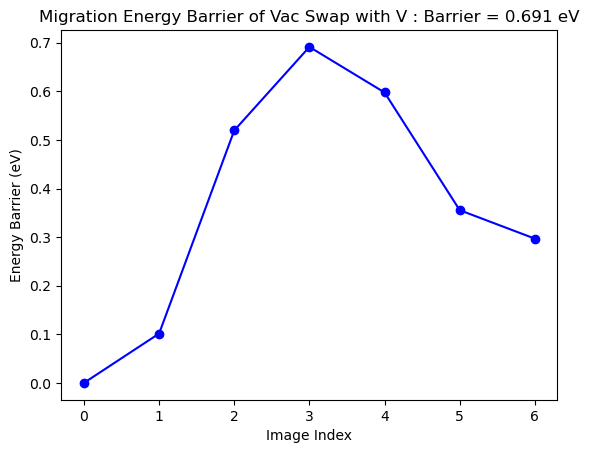

In [10]:
# Here we plot the relative energies of the vacancy diffusion calculation 
scaled_energies = [results['energies'][i] - results['energies'][0] for i in range(len(results['energies']))]

# plot the scaled energies
plt.plot(scaled_energies, marker='o', linestyle='-', color='b')
plt.xlabel('Image Index')
plt.ylabel('Energy Barrier (eV)')
plt.title(f'Migration Energy Barrier of Vac Swap with {results["target_element"]} : Barrier = {round(results["barrier"], 3)} eV')
plt.show()


## Running multiple vacancy diffusion calculations

For most vacancy diffusion calculations, you will want to run multiple vacancy diffusion calculations to infer the compositions potential energy landscape. Caution, this is best done on a GPU. Takes about 9 minutes on a 3090.

In [11]:
multi_neb = VacancyDiffusion(atoms=relaxed_atoms, model_path=model_path)

In [13]:
# pick 3 vacancy indices randomly from the len of atoms
multi_vac_indices = np.random.randint(0, len(relaxed_atoms), int(len(relaxed_atoms)/5)).tolist()

print(f"Vacancy indices: {multi_vac_indices[0:5]}")

Vacancy indices: [3174, 3507, 860, 1294, 1130]


In this multiple vacancy diffusion calculation, you can do the following:
- Change the number of images
- Change the neb method (although DyNEB is the fastest with no change in the barrier compared to VASP)
- Change whether or not we use climbing image (which is the default)
- Change the number of nearest and next nearest neighbors to sample at each vacancy index (default is 8 and 6 respectively)
- Change the relaxation parameters
- Change the seed for the random number generator
- Save the initial trajectory for debugging
- Set the output directory to save the results

This lets you create a results object that contains the vacancy diffusion calculations for each vacancy index. 

In [14]:
multi_neb_results = multi_neb.run_multiple(vacancy_indices=multi_vac_indices, 
                       num_images=5, 
                       neb_method='dyneb',
                       n_nearest=8,
                       n_next_nearest=6,
                       climb=True,
                       save_xyz=True,
                       output_dir=Path("../data/neb_workflow_data/multi_vac_diff_results_4096/"),
                       relax_fmax=0.05,
                       relax_steps=200,
                       neb_fmax=0.05,
                       neb_steps=200,
                       verbose=0,
                       rng_seed=seed
                       )



Starting 349 NEB calculations...
Post endpoint relaxation: Start energy: -37462.8515625, End energy: -37462.71484375
Post endpoint relaxation: Start energy: -37462.90625, End energy: -37462.57421875
Post endpoint relaxation: Start energy: -37462.90625, End energy: -37462.484375
Post endpoint relaxation: Start energy: -37462.89453125, End energy: -37462.84765625
Post endpoint relaxation: Start energy: -37462.890625, End energy: -37462.55859375


KeyboardInterrupt: 

## Conducting analysis on multiple vacancy diffusion calculations

Once you have the results object, you can use the analyzer object to conduct analysis on the vacancy diffusion calculations. The analyzer object is created from the VacancyDiffusion object automatically. 

However you can manually create a new analyzer object from the results object if you'd like. 

Here we show how to plot the barrier distributions for the vacancy diffusion calculations. 

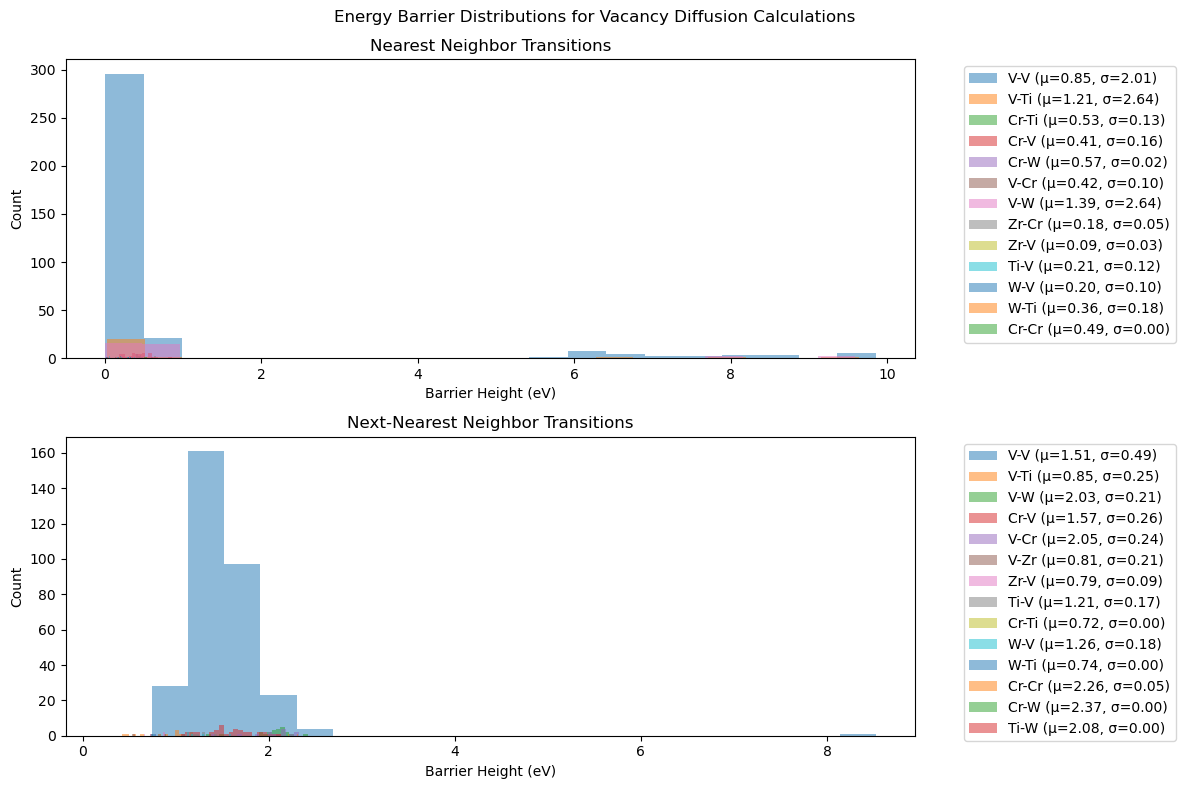

In [36]:
analyzer = multi_neb.analyzer

plot_dir = Path('../data/neb_workflow_data/multi_vac_diff_results_4096/barrier_plots')
plot_dir.mkdir(exist_ok=True)

# This plots the barrier distrutions for the vacancy diffusion calculations
analyzer.plot_barrier_distributions(save_path=plot_dir / 'barrier_distributions.png',
                                    bins=20,
                                    figsize=(12, 8),
                                    title="Energy Barrier Distributions for Vacancy Diffusion Calculations",
                                    show_stats=True,
                                    alpha=0.5,
                                    min_barrier=0.0,
                                    max_barrier=10.0)

In [1]:
# Create a directory for plots if it doesn't exist
plot_dir = Path("../data/neb_workflow_data/multi_vac_diff_results_4096/barrier_plots_by_element")
plot_dir.mkdir(exist_ok=True)

# Plot the barrier distributions by element
analyzer.plot_barriers_by_element(
    save_path=plot_dir / "barriers_by_element_box.png",
    figsize=(12, 8),
    title="Energy Barriers by Element Type",
    plot_type="box"  # Use box plot
)

# You can also plot only nearest neighbor transitions
analyzer.plot_barriers_by_element(
    save_path=plot_dir / "barriers_by_element_nn.png",
    figsize=(12, 8),
    title="Energy Barriers by Element Type",
    plot_type="bar",  # Use bar plot with error bars
    neighbor_type="nn"  # Only nearest neighbors
)

# Or only next-nearest neighbor transitions
analyzer.plot_barriers_by_element(
    save_path=plot_dir / "barriers_by_element_nnn.png",
    figsize=(12, 8),
    title="Energy Barriers by Element Type",
    neighbor_type="nnn"  # Only next-nearest neighbors
)

NameError: name 'Path' is not defined